## Capturing uncertainity in neural nets :

#### $ aleotoric(data$ $ uncertainity )$
    

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import jax.tree_util as jtu


### Model capturing aleotoric uncertainty
#### dataset containing homoskedastic noise

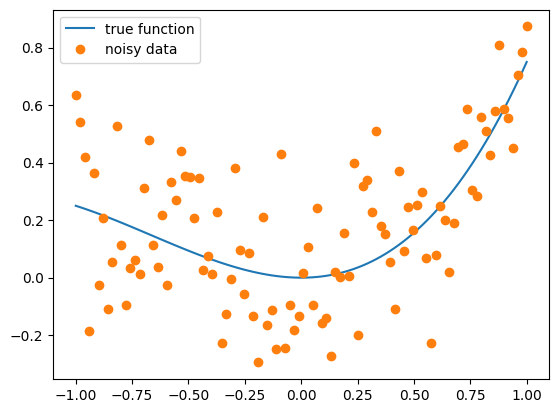

In [2]:
torch.manual_seed(42)
N = 100
x_lin= torch.linspace(-1,1,N)
fun = lambda x: 0.5 * x**2 + 0.25 * x**3
plt.plot(x_lin,fun(x_lin),label='true function');
eps = torch.randn(N) * 0.2
y = fun(x_lin) + eps

plt.plot(x_lin,y,'o',label='noisy data')
plt.legend();




In [3]:
class MeanEstimateNN1(torch.nn.Module):
    def __init__(self,n_hidden=4):
        super().__init__()
        self.fc1 = torch.nn.Linear(1,n_hidden)
        self.fc2 = torch.nn.Linear(n_hidden,n_hidden)
        self.fc3 = torch.nn.Linear(n_hidden,1)

    def forward(self,x):
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        x = torch.relu(x)
        mu_hat = self.fc3(x)
        return mu_hat        
    


In [4]:
def loss_homoskedastic_noise(model,x,y,params):
    log_noise_std = params['log_noise_std']
    mu_hat = model(x).squeeze()
    assert mu_hat.shape == y.shape
    noise_std=torch.exp(log_noise_std).expand_as(mu_hat)
    dist=torch.distributions.Normal(mu_hat,noise_std)
    return -dist.log_prob(y).mean()

In [5]:
homoskedastic_model_fixed_noise = MeanEstimateNN1()
homoskedastic_model_fixed_noise

MeanEstimateNN1(
  (fc1): Linear(in_features=1, out_features=4, bias=True)
  (fc2): Linear(in_features=4, out_features=4, bias=True)
  (fc3): Linear(in_features=4, out_features=1, bias=True)
)

In [6]:
fixed_log_noise_std = torch.log(torch.tensor(0.5))
params = {'nn_params':homoskedastic_model_fixed_noise.state_dict(),
          'log_noise_std':fixed_log_noise_std,}

loss_homoskedastic_noise(homoskedastic_model_fixed_noise,x_lin[:, None],y,params)

tensor(0.6247, grad_fn=<NegBackward0>)

In [7]:
def plot_results(y_hat,epistamic_std=None,aleatoric_std=None,model_name=""):
    plt.scatter(x_lin,y,s=10,color='C0',label='data')
    plt.plot(x_lin,fun(x_lin),color='C1',label='true function')
    plt.plot(x_lin,y_hat,color='C2',label='prediction')
    if epistamic_std is not None:
        plt.fill_between(x_lin,(y_hat-2 * epistamic_std),(y_hat+2 * epistamic_std),color='C2',alpha=0.2,label='epistemic uncertainty')

    if aleatoric_std is not None:
        plt.fill_between(x_lin,(y_hat-2 * aleatoric_std),(y_hat+2 * aleatoric_std),color='C3',alpha=0.2,label='aleatoric uncertainty')

    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()

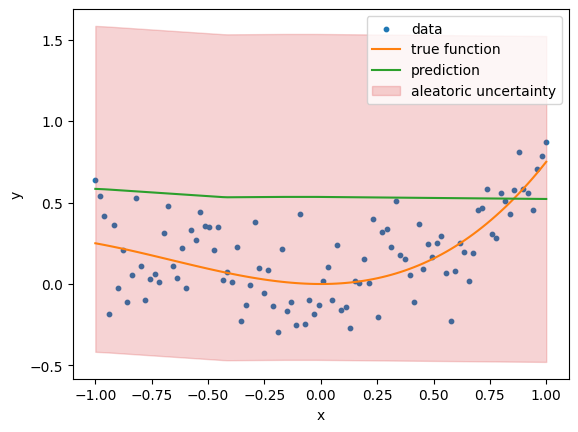

In [8]:
with torch.no_grad():
    y_hat = homoskedastic_model_fixed_noise(x_lin[:, None]).squeeze()
plot_results(y_hat,aleatoric_std=torch.exp(fixed_log_noise_std),model_name='Untrained model')

In [9]:
def train_fn(model,loss_fn,param,x,y,n_eposhs=1000,lr=0.01):
    parameter_leaves=jtu.tree_leaves(param)
    optimizer = torch.optim.Adam(parameter_leaves,lr=lr)
    for i in range(n_eposhs):
        optimizer.zero_grad()
        loss=loss_fn(model,x,y,param)
        loss.backward()
        optimizer.step()
        if i % 50 == 0:
            print(f"eposh {i} loss {loss.item():.3f}")
    return loss.item()        


In [10]:
homoskedastic_model_fixed_noise = MeanEstimateNN1()
param={
    'nn_params': list(homoskedastic_model_fixed_noise.parameters()),
    'log_noise_std': fixed_log_noise_std,
}

In [11]:
train_fn(homoskedastic_model_fixed_noise,
         loss_homoskedastic_noise,
         param,
         x_lin[:, None],
         y,
         n_eposhs=1000,
         lr=0.001)


eposh 0 loss 0.399
eposh 50 loss 0.374
eposh 100 loss 0.368


eposh 150 loss 0.367
eposh 200 loss 0.366
eposh 250 loss 0.364
eposh 300 loss 0.362
eposh 350 loss 0.357
eposh 400 loss 0.349
eposh 450 loss 0.339
eposh 500 loss 0.329
eposh 550 loss 0.322
eposh 600 loss 0.317
eposh 650 loss 0.314
eposh 700 loss 0.313
eposh 750 loss 0.312
eposh 800 loss 0.312
eposh 850 loss 0.312
eposh 900 loss 0.311
eposh 950 loss 0.311


0.3111453354358673

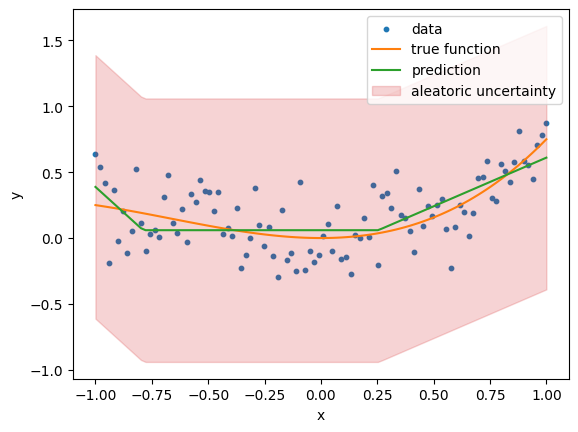

In [12]:
with torch.no_grad():
    y_hat = homoskedastic_model_fixed_noise(x_lin[:, None]).squeeze()
    aleotoric_std = torch.exp(fixed_log_noise_std)

plot_results(y_hat,aleatoric_std=aleotoric_std,model_name='Trained model')    

In [13]:
homoskedastic_model_learnable_noise=MeanEstimateNN1()
log_noise_std=torch.nn.Parameter((torch.tensor(0.0)))
homoskedastic_model_learnable_noise

MeanEstimateNN1(
  (fc1): Linear(in_features=1, out_features=4, bias=True)
  (fc2): Linear(in_features=4, out_features=4, bias=True)
  (fc3): Linear(in_features=4, out_features=1, bias=True)
)

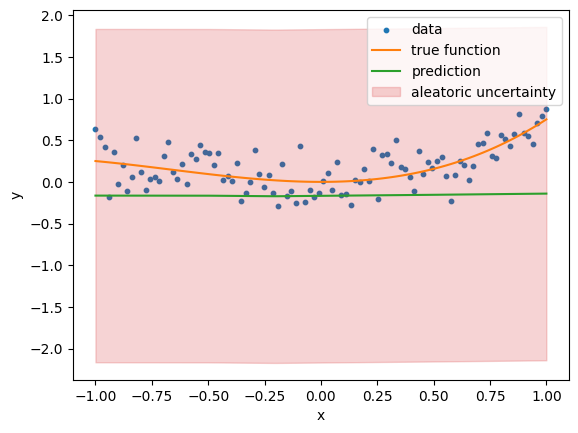

In [14]:
#plot the untrained model
with torch.no_grad():
    y_hat = homoskedastic_model_learnable_noise(x_lin[:, None]).squeeze()
    aleatoric_std = torch.exp(log_noise_std)

plot_results(y_hat,aleatoric_std=aleatoric_std,model_name='Untrained model')    

In [15]:
# train the model
homoskedastic_model_learnable_noise=MeanEstimateNN1()
param={
    'nn_params': list(homoskedastic_model_learnable_noise.parameters()),
    'log_noise_std': log_noise_std,
}

In [16]:
jtu.tree_leaves(param)

[Parameter containing:
 tensor(0., requires_grad=True),
 Parameter containing:
 tensor([[ 0.9673],
         [ 0.1447],
         [-0.2590],
         [ 0.4137]], requires_grad=True),
 Parameter containing:
 tensor([-0.3809, -0.6473,  0.7299, -0.4547], requires_grad=True),
 Parameter containing:
 tensor([[-0.1002, -0.4974,  0.3346,  0.3788],
         [ 0.1822, -0.3486, -0.4935, -0.4061],
         [ 0.3729,  0.2401,  0.4208,  0.2619],
         [ 0.1265, -0.0049, -0.3803, -0.4284]], requires_grad=True),
 Parameter containing:
 tensor([-0.4677,  0.2047, -0.2455, -0.1006], requires_grad=True),
 Parameter containing:
 tensor([[-0.2878, -0.0911, -0.3519, -0.3267]], requires_grad=True),
 Parameter containing:
 tensor([0.1659], requires_grad=True)]

In [17]:
[log_noise_std]+list(homoskedastic_model_learnable_noise.parameters())

[Parameter containing:
 tensor(0., requires_grad=True),
 Parameter containing:
 tensor([[ 0.9673],
         [ 0.1447],
         [-0.2590],
         [ 0.4137]], requires_grad=True),
 Parameter containing:
 tensor([-0.3809, -0.6473,  0.7299, -0.4547], requires_grad=True),
 Parameter containing:
 tensor([[-0.1002, -0.4974,  0.3346,  0.3788],
         [ 0.1822, -0.3486, -0.4935, -0.4061],
         [ 0.3729,  0.2401,  0.4208,  0.2619],
         [ 0.1265, -0.0049, -0.3803, -0.4284]], requires_grad=True),
 Parameter containing:
 tensor([-0.4677,  0.2047, -0.2455, -0.1006], requires_grad=True),
 Parameter containing:
 tensor([[-0.2878, -0.0911, -0.3519, -0.3267]], requires_grad=True),
 Parameter containing:
 tensor([0.1659], requires_grad=True)]

In [18]:
jtu.tree_leaves(param)==[log_noise_std]+list(homoskedastic_model_learnable_noise.parameters())

True

In [19]:
train_fn(homoskedastic_model_learnable_noise,
         loss_homoskedastic_noise,
         param,x_lin[:, None],
         y,n_eposhs=1000,
         lr=0.01)

eposh 0 loss 0.958
eposh 50 loss 0.522
eposh 100 loss 0.218


eposh 150 loss 0.109
eposh 200 loss 0.100
eposh 250 loss 0.100
eposh 300 loss 0.100
eposh 350 loss 0.100
eposh 400 loss 0.100
eposh 450 loss 0.100
eposh 500 loss 0.100
eposh 550 loss 0.100
eposh 600 loss 0.100
eposh 650 loss 0.100
eposh 700 loss 0.100
eposh 750 loss 0.100
eposh 800 loss 0.100
eposh 850 loss 0.100
eposh 900 loss 0.100
eposh 950 loss 0.100


0.09978220611810684

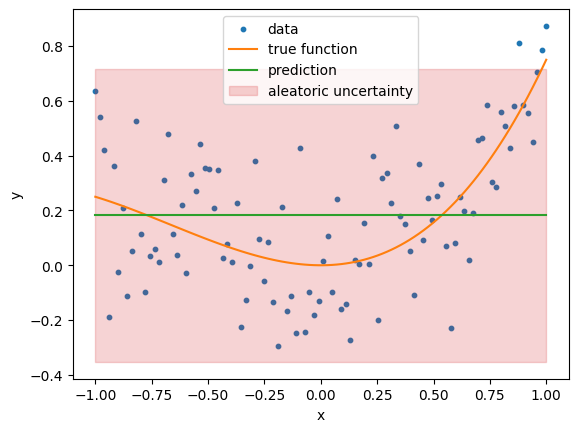

In [20]:
#plot the trained model
with torch.no_grad():
    y_hat = homoskedastic_model_learnable_noise(x_lin[:, None]).squeeze()
    aleatoric_std = torch.exp(log_noise_std)
plot_results(y_hat,aleatoric_std=aleatoric_std,model_name='Trained model')    

In [21]:
# Case 2: Heteroskedastic noise

class HetroskedasticNN(torch.nn.Module):
    def __init__(self,n_hidden=10):
        super().__init__()
        self.fc1 = torch.nn.Linear(1,n_hidden)
        self.fc2 = torch.nn.Linear(n_hidden,n_hidden)
        self.fc3 = torch.nn.Linear(n_hidden,2)

    def forward(self,x):
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        x = torch.relu(x)
        z = self.fc3(x)
        mu_hat = z[:,0]
        log_noise_std = z[:,1]
        return mu_hat,log_noise_std

In [22]:
heteroskedastic_model = HetroskedasticNN()
heteroskedastic_model

HetroskedasticNN(
  (fc1): Linear(in_features=1, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=2, bias=True)
)

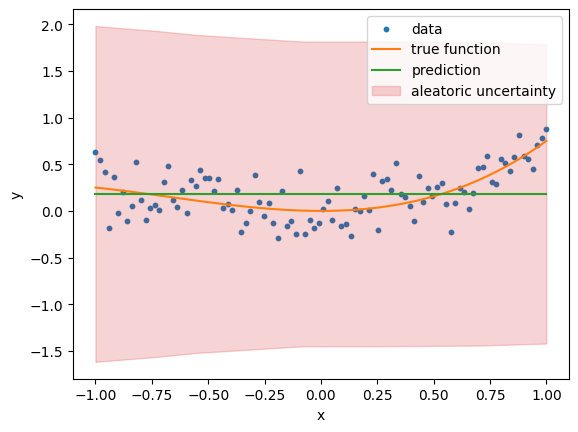

In [23]:
with torch.no_grad():
    mu_hat,log_noise_std = heteroskedastic_model(x_lin[:, None])
    aleatoric_std = torch.exp(log_noise_std)

plot_results(y_hat,aleatoric_std=aleatoric_std,model_name='Untrained model') 

In [24]:
def loss_heteroskedastic_noise(model,x,y,params):
    mu_hat,log_noise_std = model(x)
    noise_std=torch.exp(log_noise_std)
    dist=torch.distributions.Normal(mu_hat,noise_std)
    return -dist.log_prob(y).mean()

params = list(heteroskedastic_model.parameters())
train_fn(heteroskedastic_model,
         loss_heteroskedastic_noise,
         params,
         x_lin[:, None],
         y,
         n_eposhs=1000,
         lr=0.01)

eposh 0 loss 0.809
eposh 50 loss -0.077
eposh 100 loss -0.203
eposh 150 loss -0.204
eposh 200 loss -0.204
eposh 250 loss -0.204
eposh 300 loss -0.204
eposh 350 loss -0.204
eposh 400 loss -0.204
eposh 450 loss -0.205
eposh 500 loss -0.205
eposh 550 loss -0.205
eposh 600 loss -0.205
eposh 650 loss -0.205
eposh 700 loss -0.205
eposh 750 loss -0.205
eposh 800 loss -0.205
eposh 850 loss -0.205
eposh 900 loss -0.205
eposh 950 loss -0.206


-0.20577681064605713

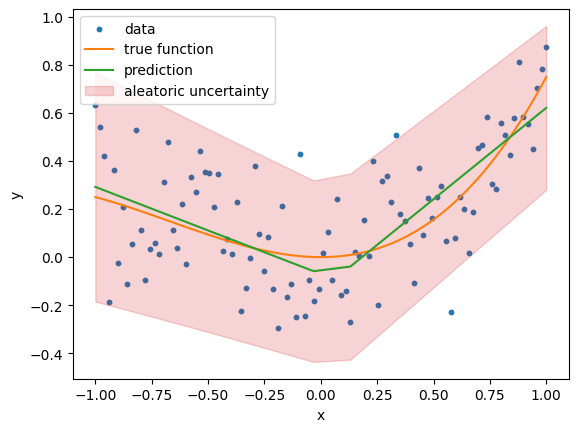

In [25]:
#plot the trained model
with torch.no_grad():
    y_hat,log_noise_std = heteroskedastic_model(x_lin[:, None])
    aleatoric_std = torch.exp(log_noise_std)
plot_results(y_hat,aleatoric_std=aleatoric_std,model_name='Trained model')

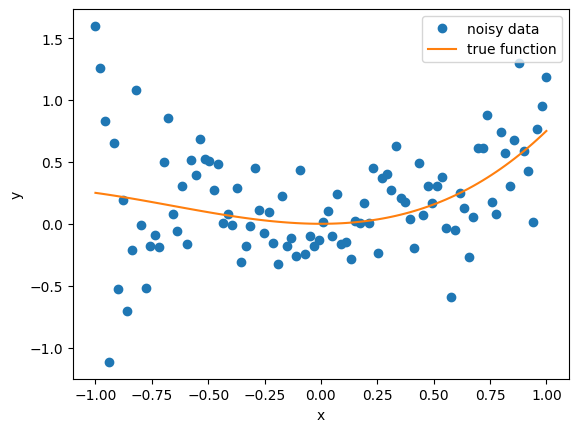

In [26]:
#data with heteroskedastic noise
torch.manual_seed(42)
N = 100
x_lin= torch.linspace(-1,1,N)
fun = lambda x: 0.5 * x**2 + 0.25 * x**3
eps = torch.randn(N) * (0.2 + 0.5 * x_lin**2)
y = fun(x_lin) + eps
plt.plot(x_lin,y,'o',label='noisy data')
plt.plot(x_lin,fun(x_lin),label='true function')
plt.xlabel('x')
plt.ylabel('y')
plt.legend();

In [27]:
homoskedastic_model_fixed_noise = MeanEstimateNN1()
fixed_log_noise_std = torch.log(torch.tensor(0.5))


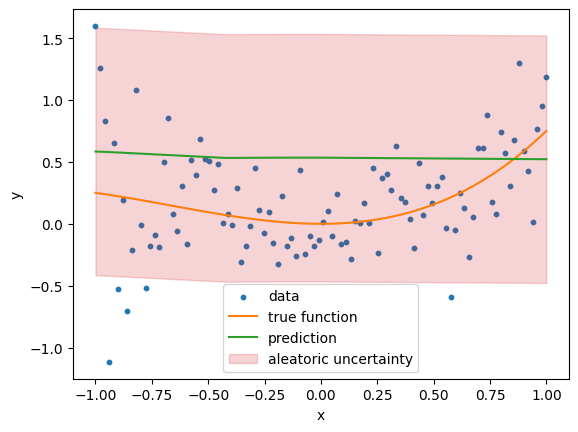

In [28]:
with torch.no_grad():
    y_hat = homoskedastic_model_fixed_noise(x_lin[:, None]).squeeze()
    aleatoric_std = torch.exp(fixed_log_noise_std)
plot_results(y_hat,aleatoric_std=aleatoric_std,model_name='Untrained model \n (homoskedastic noise)')

eposh 0 loss 0.557
eposh 50 loss 0.518
eposh 100 loss 0.501
eposh 150 loss 0.494
eposh 200 loss 0.489
eposh 250 loss 0.487
eposh 300 loss 0.473
eposh 350 loss 0.472
eposh 400 loss 0.472
eposh 450 loss 0.470
eposh 500 loss 0.469
eposh 550 loss 0.469
eposh 600 loss 0.469
eposh 650 loss 0.470
eposh 700 loss 0.470
eposh 750 loss 0.470
eposh 800 loss 0.469
eposh 850 loss 0.469
eposh 900 loss 0.469
eposh 950 loss 0.469


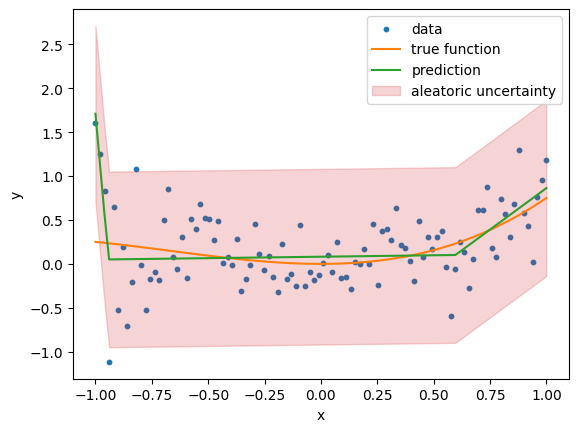

In [30]:
params = {'nn_params':list(homoskedastic_model_fixed_noise.parameters()),
            'log_noise_std':fixed_log_noise_std,}

train_fn(homoskedastic_model_fixed_noise,
         loss_homoskedastic_noise,
         params,
         x_lin[:, None],
         y,
         n_eposhs=1000,
         lr=0.01)

#plot the trained model
with torch.no_grad():
    y_hat = homoskedastic_model_fixed_noise(x_lin[:, None]).squeeze()
    aleatoric_std = torch.exp(fixed_log_noise_std)

plot_results(y_hat,aleatoric_std=aleatoric_std,model_name='Trained model \n (homoskedastic noise)')


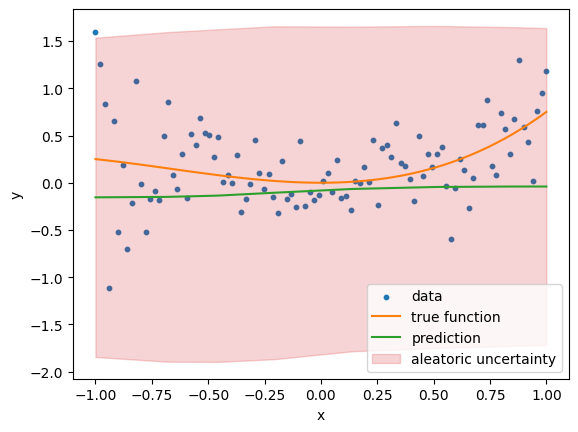

In [31]:
# Now fit the heteroskedastic model
heteroskedastic_model = HetroskedasticNN()
with torch.no_grad():
    y_hat,log_noise_std = heteroskedastic_model(x_lin[:, None])
    aleatoric_std = torch.exp(log_noise_std)

plot_results(y_hat,aleatoric_std=aleatoric_std,model_name='Untrained model \n (heteroskedastic noise)')    

In [32]:
#train the model
params = list(heteroskedastic_model.parameters())
train_fn(heteroskedastic_model,
            loss_heteroskedastic_noise,
            params,
            x_lin[:, None],
            y,
            n_eposhs=1000,
            lr=0.01)

eposh 0 loss 0.958
eposh 50 loss 0.449
eposh 100 loss 0.293
eposh 150 loss 0.290
eposh 200 loss 0.289
eposh 250 loss 0.287
eposh 300 loss 0.277
eposh 350 loss 0.252
eposh 400 loss 0.243
eposh 450 loss 0.239
eposh 500 loss 0.237
eposh 550 loss 0.235
eposh 600 loss 0.233
eposh 650 loss 0.232
eposh 700 loss 0.232
eposh 750 loss 0.230
eposh 800 loss 0.230
eposh 850 loss 0.229
eposh 900 loss 0.229
eposh 950 loss 0.228


0.22845828533172607

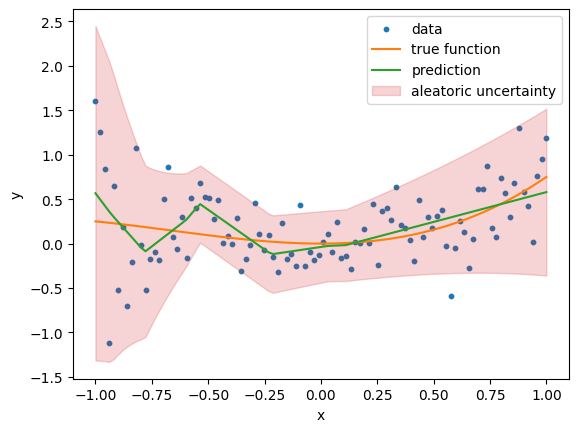

In [33]:
# plot the trained model
with torch.no_grad():
    y_hat,log_noise_std = heteroskedastic_model(x_lin[:, None])
    aleatoric_std = torch.exp(log_noise_std)

plot_results(y_hat,aleatoric_std=aleatoric_std,model_name='Trained model \n (heteroskedastic noise)')    

In [40]:
# Case 3: Epistatmic uncertainty : Bayesian neural network with laplace approximation
# MAP estimate
def negetive_log_prior(model):
    log_prior=0.0
    for param in model.parameters():
        log_prior += torch.distributions.Normal(0,1).log_prob(param).sum()
    return -log_prior

def negetive_log_likelihood(model,x,y,log_noise_std):
    mu_hat = model(x).squeeze()
    assert mu_hat.shape == y.shape
    noise_std = torch.exp(log_noise_std).expand_as(mu_hat)
    dist = torch.distributions.Normal(mu_hat,noise_std)
    return -dist.log_prob(y).mean()


def negetive_log_joint(model,x,y,log_noise_std):
    return negetive_log_likelihood(model,x,y,log_noise_std) + negetive_log_prior(model)    

In [41]:
def custom_loss_fn(model,x,y,params):
    log_noise_std = params['log_noise_std']
    return negetive_log_joint(model,x,y,log_noise_std)

torch.manual_seed(42)
laplace_model = MeanEstimateNN1()
fixed_log_noise_std = torch.log(torch.tensor(0.2))
params = {
            'nn_params':list(laplace_model.parameters()),
            'log_noise_std':fixed_log_noise_std,
            }

train_fn(laplace_model,
         custom_loss_fn,
         params,
         x_lin[:, None],
         y,
         n_eposhs=1000,
         lr=0.01)

eposh 0 loss 35.074
eposh 50 loss 32.365
eposh 100 loss 32.127
eposh 150 loss 32.098
eposh 200 loss 32.096
eposh 250 loss 32.096
eposh 300 loss 32.096
eposh 350 loss 32.096
eposh 400 loss 32.096
eposh 450 loss 32.096
eposh 500 loss 32.096
eposh 550 loss 32.096
eposh 600 loss 32.096
eposh 650 loss 32.096
eposh 700 loss 32.096
eposh 750 loss 32.096
eposh 800 loss 32.096
eposh 850 loss 32.096
eposh 900 loss 32.096
eposh 950 loss 32.096


32.09635925292969

In [ ]:
with torch.no_grad():
    y_hat = laplace_model(x_lin[:, None]).squeeze()
    aleatoric_std = torch.exp(fixed_log_noise_std)

plot_results(y_hat,aleatoric_std=aleatoric_std,model_name='MAP estimate \n (laplace approximation)')        